# Analyse and plot output from OpenIFS

Files are named EXPID_FREQ_STARTDATE_ENDDATE_GRID_LEVEL.nc 
* FREQ can be "1d" (daily), "1m" (monthly), etc. 
* GRID can be "regular" (regular grid where lon, lat are 1D) or "reduced" (original reduced Gaussian grid).
* LEVEL can be "sfc" (surface variables, e.g. 2m temp, precipitation), "pl" (pressure levels), "pv" (potential vorticity levels)

See ECMWF parameter database for variable names and descriptions. 
https://apps.ecmwf.int/codes/grib/param-db

In [26]:
# Load necessary modules
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean 
import os

## Where to find data

In [27]:
# Find esm-experiments in your WORK dir
esmdir = '%s/esm-experiments/' % (os.environ['WORK'],)

## Read OpenIFS data

In [29]:
# Frequency to read in 
freq = '1d'
# Which runs to read
expnames = ['OIFS-KJK001']
# Which time periods to read in
times = [slice('1979-01-01','1979-07-01')]
# Which levels to read for each run
levels = ['sfc','pl']

In [30]:
# Put data from all runs in one list
ds_all = []

for exp,time in zip(expnames, times):
    
    ds_lev = []
    
    for lev in levels:
        # Find all relevant files with wildcards
        files = '%s/%s/outdata/oifs/*%s*regular_%s.nc' % (esmdir,exp,freq,lev)
        print(files)
        
        # Open multi-file data set. We need to use cftime since the normal python calendar stops working after 2300. 
        # We only read time set in the times list above
        # Also, we rename time variable from time_counter to time to make life easier
        # Optimized reading from Sebastian Wahl
        _ds = xr.open_mfdataset(files,combine='nested', 
                                concat_dim="time_counter", use_cftime=True,
                                data_vars='minimal', coords='minimal', compat='override',
                                parallel=True).rename({'time_counter':'time'}).sel(time=time)
        
        ds_lev.append(_ds)
        
    ds = xr.merge(ds_lev)
        
    ds_all.append(ds)

/gxfs_work1/geomar/smomw352/esm-experiments//OIFS-KJK001/outdata/oifs/*1d*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//OIFS-KJK001/outdata/oifs/*1d*regular_pl.nc


In [31]:
ds_all[0]

<xarray.Dataset>
Dimensions:               (lat: 192, lon: 384, time: 181, axis_nbounds: 2, pressure_levels: 39)
Coordinates:
  * lat                   (lat) float32 -89.53 -88.59 -87.66 ... 88.59 89.53
  * lon                   (lon) float32 0.4688 1.406 2.344 ... 357.7 358.6 359.5
    time_centered         (time) object dask.array<chunksize=(31,), meta=np.ndarray>
  * time                  (time) object 1979-01-01 12:00:00 ... 1979-06-30 12...
  * pressure_levels       (pressure_levels) float32 1e+05 9.25e+04 ... 5.0 3.0
Dimensions without coordinates: axis_nbounds
Data variables: (12/78)
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(31, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(31, 2), meta=np.ndarray>
    sstk                  (time, lat, lon) float32 dask.array<chunksize=(31, 192, 384), meta=np.ndarray>
    ci                    (time, lat, lon) float32 dask.array<chunksize=(31, 192, 384), meta=np.ndarray>
    es                    (time, lat, lon) float32 dask.array<chunksize=(31, 192, 384), meta=np.ndarray>
    tclw                  (time, lat, lon) float32 dask.array<chunksize=(31, 192, 384), meta=np.ndarray>
    ...                    ...
    t                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(31, 39, 192, 384), meta=np.ndarray>
    u                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(31, 39, 192, 384), meta=np.ndarray>
    v                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(31, 39, 192, 384), meta=np.ndarray>
    q                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(31, 39, 192, 384), meta=np.ndarray>
    w                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(31, 39, 192, 384), meta=np.ndarray>
    etadot                (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(31, 39, 192, 384), meta=np.ndarray>
Attributes:
    name:         ECE3_1d_19790101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2023-Jun-15 10:47:01 GMT
    uuid:         246a5336-f4a2-46b4-8dae-526d2c6ca7a9
    history:      Thu Jun 15 12:59:40 2023: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.9.3 (Homepage = http://nco.sf.ne...

## Plot mean T2m 

In [7]:
mean_list = []

for i,_ds in enumerate(ds_all):
    
    # Select T2m
    _mean = _ds['2t'].mean('time').compute()
    # Add experiment as coordinate
    _mean.coords['exp'] = expnames[i]
    
    mean_list.append(_mean)
    
ds_mean = xr.concat( mean_list, dim='exp' )

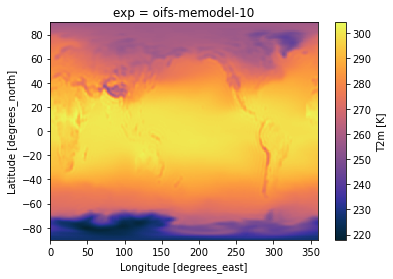

In [8]:
cw = {'label': 'T2m [K]'}
cmap = cmocean.cm.thermal

if len(expnames) == 1:
    ds_mean.plot(x='lon',y='lat',
                 cmap=cmap,
                 cbar_kwargs=cw)
else:
    ds_mean.plot(x='lon',y='lat',col='exp',col_wrap=2,
                 cmap=cmap,
                 cbar_kwargs=cw)

## Plot surface solar radiation and precip over Honolulu

In [9]:
flux_list = []

for i, _ds in enumerate(ds_all):
    
    # Select solar rad
    # Logic is SSR = Surface Solar Radiation
    # Similarly, TTR = Top of atmosphere Thermal Radiation
    # OpenIFS grid has lon=[0,360]
    _sw = _ds['ssr'].sel(lat=21.3,method='nearest').sel(lon=202.1,method='nearest')
    
    # Select precip
    _tp = _ds['tp'].sel(lat=21.3,method='nearest').sel(lon=202.1,method='nearest')
    
    # Put into one dataset
    _ds = xr.merge( [_sw, _tp])
    _ds.coords['exp'] = expnames[i]
    
    flux_list.append(_ds)
    
ds_flux = xr.concat( flux_list, dim='exp' )

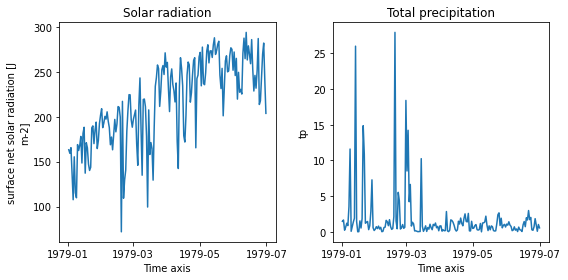

In [12]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
axs = ax.flat

# Precip is in m/s
# Scale to mm/day
pscale = 1000 * 86400

ds_flux['ssr'].plot(hue='exp',ax=axs[0])
(ds_flux['tp'] * pscale).plot(hue='exp',ax=axs[1])

axs[0].set_title('Solar radiation')
axs[1].set_title('Total precipitation')

fig.tight_layout()

## Plot jet stream over North Atlantic

In [38]:
jet_list = []

for i, _ds in enumerate(ds_all):
    
    # Select zonal wind
    # over North Atlantic (60W-0E, 20-70N)
    # take zonal and time mean
    # Compute now, so we dont need to do it again
    _u = _ds['u'].sel(lon=slice(300,360)).sel(lat=slice(20,70)).mean('lon').mean('time').compute()
    
    # Select zonal wind
    #_u = _ds['u'].sel(pv_levels=2e-6).mean('time')
    
    _u.coords['exp'] = expnames[i]
    
    jet_list.append(_u)
    
ds_jet = xr.concat(jet_list, dim='exp')

In [33]:
ds_jet

<xarray.DataArray 'u' (exp: 1, pressure_levels: 39, lat: 54)>
dask.array<broadcast_to, shape=(1, 39, 54), dtype=float32, chunksize=(1, 39, 54), chunktype=numpy.ndarray>
Coordinates:
  * lat              (lat) float32 20.16 21.09 22.03 22.97 ... 67.97 68.91 69.84
  * pressure_levels  (pressure_levels) float32 1e+05 9.25e+04 ... 5.0 3.0
  * exp              (exp) <U11 'OIFS-KJK001'

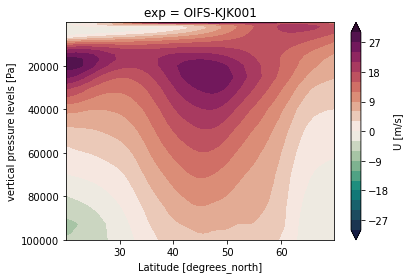

In [46]:
# Set colourmap, levels and label
cmap = cmocean.cm.curl
levels = np.linspace(-30,30,21)
cw = {'label': 'U [m/s]'}

if len(expnames) == 1:
    
    fig, ax = plt.subplots(1,1)
    ds_jet.isel(exp=0).plot.contourf(x='lat', y='pressure_levels', 
                                     cmap=cmap,
                                     levels=levels,
                                     extend='both',
                                     cbar_kwargs=cw)
    ax.invert_yaxis()
    
else:
    p, = ds_jet.plot.contourf(x='lat',y='pressure_levels',col='exp',col_wrap=2,
                              cmap=cmap,
                              levels=levels,
                              extend='both',
                              cbar_kwargs=cw)
    
    for ax in p.ax.flat:
        ax.invert_yaxis()

## Your own plots